# Intramolecular Potential Energy Surfaces

## Definitions
**Potential Energy Surface**: the energy of a system or collection of atoms, in terms of certain parameters, normally the positions of the atoms. [reference](https://chem.libretexts.org/Courses/University_of_California_Davis/UCD_Chem_107B%3A_Physical_Chemistry_for_Life_Scientists/Chapters/2%3A_Chemical_Kinetics/2.06%3A_Potential_Energy_Surfaces).

## Goal
Our goal in this exercise is to understand the way the energy of the molecule changes as we rotate the nitro group relative to the benzyl group. We could just rotate the nitro group a certain number of degrees, calculate an energy, and then repeat as many times as we need to get a decent looking plot. However, one problem with this is that the bond lengths, and perhaps other angles not associated with the rotation, may actually want to change to get to a lower energy. The best way to make sure that we are getting the lowest energy associated with the rotation is to rotate the molecule, freeze the dihedrals, and then optimize the geometry - letting all other coordinates change except the frozen dihedrals. This is called a **constrained optimization**.

## Calculating the rotation Potential Energy Surface
First we import the python modules we need to use for our calculations.

In [1]:
import psi4
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Setting up the molecule and getting the initial energy
The first code block will set up our molecule as an object in Psi4 using the function `psi4.geometry`. You will need to add in the final coordinates of your molecule from the nitrobenzene optimization from the last exercises. As before, we can use Psi4 to calculate different attributes of the molecule using the basis set that we specify. In this case we will use the Hartree-Fock method (SCF) and the cc-pVDZ basis set to calculate the energy of the molecule and store it in a value E for printing in the notebook when the calculation is complete. It is useful to check to make sure that this energy is the same as the one from the final geometry in the optimization - just to make sure that the geometry that you have put in is OK.

We can also print the positions of all the atoms at any time using `molecule.print_out_in_angstrom()` and all of the interatomic distances using `molecule.print_distances()`. We will print these to a file called ‘geometry_initial’ just as an example, but we don’t really need this information right now.

In [2]:
# set the amount of memory that you will need
psi4.set_memory('2 GB')

# set several threads to run to get the results a bit faster
psi4.set_num_threads(2)

# set the molecule name for your files and plots
molecule_name = "nitrobenzenepes"

# enter the starting coordinates of the atoms in your molecule
# note that the "0 1" is the charge and multiplicity of the molecule;
# the "symmetry c1" term forces Psi4 to not use molecular symmetry
nitrobenzene = psi4.geometry("""
symmetry c1
0 1
         C           -0.095064772343     0.146295623041     0.059537205186
         C            1.283018363291     0.142649668478     0.196784140588
         C            1.990331050963    -0.960422939516    -0.254006621934
         C            1.318416263743    -2.031528686933    -0.828747057589
         C           -0.064188925162    -2.007366882283    -0.956737400211
         C           -0.784558755686    -0.910752841459    -0.510319723340
         N           -0.848855091435     1.308105436534     0.533445635977
         O           -0.233820735922     2.201021978360     1.018562061794
         O           -2.029554627386     1.286506572614     0.404620639986
         H            1.779858487179     0.986578029758     0.646345969034
         H            3.066459468369    -0.982350238052    -0.155873129710
         H            1.875676025875    -2.889960105077    -1.178879784359
         H           -0.584173157007    -2.842448011438    -1.404447615844
         H           -1.857675444135    -0.866918749314    -0.597782154057
""")

# calculate the initial energy of the molecule using the Hartree-Fock method and the cc-pVDZ basis set to a file
psi4.set_output_file(F'{molecule_name}_energy_initial.dat', False)
E = psi4.energy('scf/cc-pVDZ',molecule=nitrobenzene)

# print atomic coordinates and interatomic distances to a file
psi4.set_output_file(F'{molecule_name}_geometry_initial.dat', False)
nitrobenzene.print_out_in_angstrom()
nitrobenzene.print_distances()

#print the energy out to the notebook
print('The energy is: ', E) # should be -434.2111965383506


  Memory set to   1.863 GiB by Python driver.
  Threads set to 2 by Python driver.
The energy is:  -434.2111965382163


## Determine the dihedral to be rotated and set up the angles to do the calculation
Now that we have the molecule setup, we need to decide which dihedrals needs to be rotated and then set up an array with the angles that we want to do the calculations. The definition of a dihedral angle is the angle between two planes. We know that three points define a plane, so to specify a dihedral angle, you specify four atom numbers. The first three numbers define the first plane and the last three numbers define the second plane. The two middle numbers are used in both plane definitions.

We want to rotate the nitro group around the plane of benzene. The first three numbers will be the atoms that form the nitro group: one of the oxygens, the nitrogen, and the carbon the nitrogen is attached to. The second three numbers will define the plane of the benzene ring: the nitrogen, the carbon the nitrogen is attached to, and an adjacent carbon in the aromatic ring. There are two oxygens in the nitro group, so we will define two dihedral angles, one based on each, `dihedral1` and `dihedral2`.

Since we won't be using the Avogadro software, I will provide you with the dihedrals to be rotated around.


In [6]:
# set the dihedrals to be rotated around
dihedral1 = "2 1 7 8 "
dihedral2 = "6 1 7 9 "

One of the challenges of computations like this is to make sure that the number of calculations is reasonable to give a smooth potential energy plot. For different molecules, you may have to use a different step size for your angle rotation. But if you choose too big of a step size, the optimization may fail. If you take too small of a step, then it will take a long time to generate the calculations. In this example, we will initially rotate our dihedral angle by increments of 10 degrees. We will have these values into a numpy array called `phi`.

In [7]:
# set the values of the dihedral for the calculations
# note that each value will correspond to a geometry optimization for each of the frozen dihedral values
import numpy as np
phi = np.linspace(start=0, stop=180, num=19)
print(phi)

[  0.  10.  20.  30.  40.  50.  60.  70.  80.  90. 100. 110. 120. 130.
 140. 150. 160. 170. 180.]


## Calculating the PES
Now that we have the basics set up, we need to actually run the constrained optimizations for each of the dihedral values. First, we will set up an output file and run each of the optimizations. The energy of the final optimized structure will be saved in the list `energy_values`. Then we will plot the energies for each of the dihedral angles involved.

To help speed up the process, we are going to switch the basis set to the 3-21G basis (a smaller basis than the cc-pVDZ one we have used up to this point). You will know all of the computations are complete when you see “All optimizations complete!”.

In [8]:
psi4.set_output_file('nitrobenzene_torsionscan.dat', False)

#Set up empty list to store the energy values
energy_values = []

# loop over all of the dihedral values
for P in phi:
    print(F'The value of the frozen dihedrals is {P}')
    #set up a string needed by Psi4 to freeze the dihedral
    frozen_dihedral = F'{dihedral1} {P} {dihedral2} {P}'
    #set the fixed dihedral
    psi4.set_module_options('optking', {'fixed_dihedral': frozen_dihedral})  
    # we're going to loosen up the convergence criteria to speed this process up
    # we are going to give it more cycles to optimize
    psi4.set_module_options('optking', {'g_convergence': 'gau_loose'})
    psi4.set_module_options('optking', {'geom_maxiter': 100})
    E = psi4.optimize('scf/3-21G', molecule=nitrobenzene)
    energy_values.append(E)

print('All optimizations complete!')

The value of the frozen dihedrals is 0.0


/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:12: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'fixed_dihedral': frozen_dihedral})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:15: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'g_convergence': 'gau_loose'})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:16: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'geom_maxiter':

Optimizer: Optimization complete!
The value of the frozen dihedrals is 10.0


/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:12: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'fixed_dihedral': frozen_dihedral})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:15: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'g_convergence': 'gau_loose'})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:16: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'geom_maxiter':

Optimizer: Optimization complete!
The value of the frozen dihedrals is 20.0


/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:12: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'fixed_dihedral': frozen_dihedral})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:15: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'g_convergence': 'gau_loose'})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:16: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'geom_maxiter':

Optimizer: Optimization complete!
The value of the frozen dihedrals is 30.0


/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:12: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'fixed_dihedral': frozen_dihedral})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:15: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'g_convergence': 'gau_loose'})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:16: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'geom_maxiter':

Optimizer: Optimization complete!
The value of the frozen dihedrals is 40.0


/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:12: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'fixed_dihedral': frozen_dihedral})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:15: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'g_convergence': 'gau_loose'})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:16: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'geom_maxiter':

Optimizer: Optimization complete!
The value of the frozen dihedrals is 50.0


/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:12: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'fixed_dihedral': frozen_dihedral})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:15: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'g_convergence': 'gau_loose'})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:16: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'geom_maxiter':

Optimizer: Optimization complete!
The value of the frozen dihedrals is 60.0


/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:12: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'fixed_dihedral': frozen_dihedral})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:15: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'g_convergence': 'gau_loose'})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:16: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'geom_maxiter':

Optimizer: Optimization complete!
The value of the frozen dihedrals is 70.0


/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:12: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'fixed_dihedral': frozen_dihedral})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:15: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'g_convergence': 'gau_loose'})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:16: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'geom_maxiter':

Optimizer: Optimization complete!
The value of the frozen dihedrals is 80.0


/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:12: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'fixed_dihedral': frozen_dihedral})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:15: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'g_convergence': 'gau_loose'})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:16: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'geom_maxiter':

Optimizer: Optimization complete!
The value of the frozen dihedrals is 90.0


/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:12: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'fixed_dihedral': frozen_dihedral})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:15: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'g_convergence': 'gau_loose'})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:16: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'geom_maxiter':

Optimizer: Optimization complete!
The value of the frozen dihedrals is 100.0


/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:12: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'fixed_dihedral': frozen_dihedral})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:15: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'g_convergence': 'gau_loose'})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:16: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'geom_maxiter':

Optimizer: Optimization complete!
The value of the frozen dihedrals is 110.0


/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:12: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'fixed_dihedral': frozen_dihedral})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:15: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'g_convergence': 'gau_loose'})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:16: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'geom_maxiter':

Optimizer: Optimization complete!
The value of the frozen dihedrals is 120.0


/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:12: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'fixed_dihedral': frozen_dihedral})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:15: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'g_convergence': 'gau_loose'})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:16: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'geom_maxiter':

Optimizer: Optimization complete!
The value of the frozen dihedrals is 130.0


/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:12: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'fixed_dihedral': frozen_dihedral})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:15: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'g_convergence': 'gau_loose'})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:16: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'geom_maxiter':

Optimizer: Optimization complete!
The value of the frozen dihedrals is 140.0


/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:12: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'fixed_dihedral': frozen_dihedral})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:15: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'g_convergence': 'gau_loose'})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:16: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'geom_maxiter':

Optimizer: Optimization complete!
The value of the frozen dihedrals is 150.0


/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:12: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'fixed_dihedral': frozen_dihedral})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:15: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'g_convergence': 'gau_loose'})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:16: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'geom_maxiter':

Optimizer: Optimization complete!
The value of the frozen dihedrals is 160.0


/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:12: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'fixed_dihedral': frozen_dihedral})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:15: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'g_convergence': 'gau_loose'})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:16: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'geom_maxiter':

Optimizer: Optimization complete!
The value of the frozen dihedrals is 170.0


/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:12: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'fixed_dihedral': frozen_dihedral})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:15: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'g_convergence': 'gau_loose'})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:16: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'geom_maxiter':

Optimizer: Optimization complete!
The value of the frozen dihedrals is 180.0


/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:12: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'fixed_dihedral': frozen_dihedral})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:15: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'g_convergence': 'gau_loose'})
/var/folders/kq/xm93vd1j2878_9vh4r67_hzh0000gn/T/ipykernel_71407/2324783982.py:16: FutureWarning: Using `psi4.set_module_options(<module>, {<key>: <val>})` instead of `psi4.set_options({<module>__<key>: <val>})` is deprecated, and as soon as 1.5 it will stop working

  psi4.set_module_options('optking', {'geom_maxiter':

Optimizer: Optimization complete!
All optimizations complete!


## Plotting how energy changes during the potential energy scan
Let's plot how the energy changes at each value of `phi`.

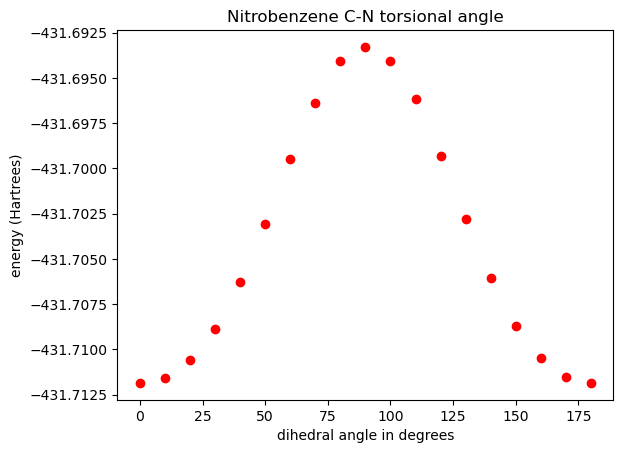

In [9]:
plt.figure()
plt.plot(phi, energy_values, 'ro')
plt.xlabel('dihedral angle in degrees')
plt.ylabel('energy (Hartrees)')
plt.title('Nitrobenzene C-N torsional angle')
plt.show()

## Exercise
Change the units from Hartrees to kJ/mol and scale the values such that the minimum is at zero.

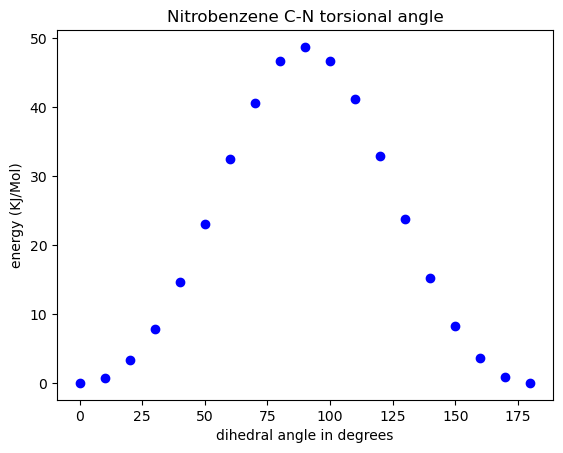

In [11]:
# do the unit conversion
energy_values_kJ =[e*2625.5 for e in energy_values]
# and let's define the lowest energy to be zero
energy_values_kJ = [e - min(energy_values_kJ) for e in energy_values_kJ]

# determine the maximum energy (for setting y axes limits)
Emax = max(energy_values_kJ)

# plot the energies at each iteration
plt.figure()
plt.plot(phi, energy_values_kJ, 'bo')
plt.xlabel('dihedral angle in degrees')
plt.ylabel('energy (KJ/Mol)')
plt.title('Nitrobenzene C-N torsional angle')
plt.show()